# Exploratory Descriptives: Fatalities in Aghanistan

We need to:
- determine what we want to predict
- what variables we will use
- how we will train our data

**Source of data:** [Historical data of anti-civilian violence, from the Armed Conflict Location & Event Data (ACLED)](https://acleddata.com/category/violence-against-civilians/)

In [100]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import plotly.express as px 
import plotly.io as pio
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import scipy
from numpy.typing import ArrayLike
from sklearn.linear_model import LinearRegression, QuantileRegressor
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from lightgbm import LGBMRegressor
from matplotlib.ticker import ScalarFormatter

seed = 42

In [69]:
#Dataset
df_acled = pd.read_csv("civilians_May02-1.csv")
df_acled

#One of our only constants is fatalities
#The rest of the variable could be good for clustering purposes

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,BRA97137,2025-05-02,2025,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Brazil),NaN,Political militia,...,Fortaleza,-3.7172,-38.5431,1,Diario do Nordeste,Subnational,"On 2 May 2025, in Fortaleza (Ceara), two unide...",1,NaN,1746490561
1,BRA97138,2025-05-02,2025,1,Political violence,Violence against civilians,Attack,Unidentified Gang and/or Police Militia,NaN,Political militia,...,Fortaleza,-3.7172,-38.5431,1,Diario do Nordeste; Meio Norte,Subnational-National,"On 2 May 2025, in Fortaleza (Ceara), unidentif...",0,NaN,1746490561
2,BRA97139,2025-05-02,2025,1,Political violence,Violence against civilians,Attack,Unidentified Gang and/or Police Militia,NaN,Political militia,...,Ibateguara,-8.9737,-35.9279,1,Alagoas 24 Horas,Subnational,"On 2 May 2025, in Ibateguara (Alagoas), two un...",1,NaN,1746490561
3,BRA97142,2025-05-02,2025,1,Political violence,Violence against civilians,Attack,Unidentified Gang and/or Police Militia,NaN,Political militia,...,Sao Miguel dos Campos,-9.7811,-36.0936,1,Alagoas 24 Horas,Subnational,"On 2 May 2025, in Sao Miguel dos Campos (Alago...",1,NaN,1746490561
4,BRA97143,2025-05-02,2025,1,Political violence,Violence against civilians,Attack,Unidentified Gang and/or Police Militia,NaN,Political militia,...,Serra,-20.1286,-40.3078,1,ES Hoje,Subnational,"On 2 May 2025, in Serra (Espirito Santo), two ...",1,NaN,1746490561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400683,LBY1,1997-01-02,1997,1,Political violence,Violence against civilians,Attack,Military Forces of Libya (1969-2011),NaN,State forces,...,Al Kufrah,24.1670,23.2700,2,Reuters,International,The government of Libya executed two American ...,8,NaN,1685401321
400684,ALG1,1997-01-01,1997,1,Political violence,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,Rebel group,...,Douaouda,36.6725,2.7894,1,Algeria Watch,Other,5 January: Beheading of 5 citizens in Douaouda...,5,NaN,1582579226
400685,SIE6,1997-01-01,1997,3,Political violence,Violence against civilians,Attack,Military Forces of Sierra Leone (1996-1997),NaN,State forces,...,York Island,7.5317,-12.4694,2,No Peace Without Justice; SL-LED,Local partner-New media,"Around 1 January 1997 (month of), Military For...",0,NaN,1670286851
400686,ANG1,1997-01-01,1997,3,Political violence,Violence against civilians,Attack,UNITA: National Union for the Total Independen...,NaN,Political militia,...,Mumbue,-13.9000,17.3000,1,Angola Cronologia,National,30 cadavers found October 14,30,NaN,1743467517


In [70]:
df_af = df_acled[df_acled['country'] == "Afghanistan"]
df_af

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
457,AFG69759,2025-04-29,2025,1,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),NaN,State forces,...,Khost,33.3395,69.9204,1,Zawia News,National,"On 29 April 2025, the Taliban shot and severel...",0,NaN,1746565730
1402,AFG69746,2025-04-23,2025,1,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),NaN,State forces,...,Gozargah-e-Noor,36.2266,69.5744,2,Amu TV,National,"On 23 April 2025, Taliban forces detained and ...",0,NaN,1746560210
2179,AFG69714,2025-04-17,2025,1,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),NaN,State forces,...,Tirinkot,32.6268,65.8733,1,Afghan Islamic Press News Agency; Etilaat e Roz,National,"On 17 April 2025, 15 people were publicly flog...",0,NaN,1745445409
2313,AFG69716,2025-04-16,2025,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Afghanistan),NaN,Political militia,...,Chahar Sang,31.9662,65.5267,1,Etilaat e Roz; Hasht-e Subh; Shafaqna,National,"On 16 April 2025, one imam was shot and killed...",1,NaN,1745445409
2620,AFG69705,2025-04-14,2025,2,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),NaN,State forces,...,Pasaband,33.6896,64.8531,2,Amu TV; Hasht-e Subh,National,"Around 14 April 2025 (as reported), two civili...",0,NaN,1745445409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337675,AFG80,2017-01-02,2017,1,Political violence,Violence against civilians,Abduction/forced disappearance,Taliban,NaN,Rebel group,...,Takhta Pul,31.3206,65.9611,2,Pajhwok Afghan News; News Yemen,National-International,"On 2 January 2017, 10 laborers were abducted b...",0,NaN,1618524512
337702,AFG29067,2017-01-02,2017,1,Political violence,Violence against civilians,Attack,Taliban,NaN,Rebel group,...,Ghazni,33.5508,68.4225,1,Voice of Jihad,Other,2 Jan 2017: 6 civilians accused of robbery and...,0,NaN,1710267738
337732,AFG20,2017-01-01,2017,1,Political violence,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Afghanistan),NaN,Political militia,...,Herat,34.3482,62.1997,1,Herat TV; Aina TV; TOLO News; Khaama Press; Af...,Subnational-National,"Jan 1, 2017: A bomb in a Shi'a mosque in Bagh ...",1,NaN,1618518785
337744,AFG24,2017-01-01,2017,2,Political violence,Violence against civilians,Attack,Taliban,NaN,Rebel group,...,Nawa-i-Barikzayi,31.3918,64.3190,2,Khaama Press; Pajhwok Afghan News,National,Reported 5 Jan 2017: Taliban killed a female p...,1,women targeted: government officials,1638981227


In [71]:
#Converting Timestamps
df_acled['readable_date'] = pd.to_datetime(df_acled['timestamp'], unit='s')
df_af.loc[:, 'readable_date'] = pd.to_datetime(df_af['timestamp'], unit='s')

df_af.to_csv('afgh_may25.csv', index=False)

/var/folders/z3/_4r433cx6vb0c7n920xjj_g80000gn/T/ipykernel_54908/4252326948.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
#Counting and adjusting for missings
#df_af.drop(['tags'], axis=1, inplace=True) #Dropped 'admin3' and 'tags', most were completely missing

null_percent = df_af[['actor1','assoc_actor_1','inter1','actor2','assoc_actor_2','inter2']].isnull().mean() * 100
null_percent

actor1            0.000000
assoc_actor_1    93.929471
inter1            0.000000
actor2            0.000000
assoc_actor_2    52.720403
inter2            0.000000
dtype: float64

In [73]:
#Refilling with 'unknowns'

df_af.loc[:, ['assoc_actor_1', 'assoc_actor_2']] = df_af[['assoc_actor_1', 'assoc_actor_2']].fillna('Unknown')
df_af

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp,readable_date
457,AFG69759,2025-04-29,2025,1,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),Unknown,State forces,...,33.3395,69.9204,1,Zawia News,National,"On 29 April 2025, the Taliban shot and severel...",0,NaN,1746565730,2025-05-06 21:08:50
1402,AFG69746,2025-04-23,2025,1,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),Unknown,State forces,...,36.2266,69.5744,2,Amu TV,National,"On 23 April 2025, Taliban forces detained and ...",0,NaN,1746560210,2025-05-06 19:36:50
2179,AFG69714,2025-04-17,2025,1,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),Unknown,State forces,...,32.6268,65.8733,1,Afghan Islamic Press News Agency; Etilaat e Roz,National,"On 17 April 2025, 15 people were publicly flog...",0,NaN,1745445409,2025-04-23 21:56:49
2313,AFG69716,2025-04-16,2025,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Afghanistan),Unknown,Political militia,...,31.9662,65.5267,1,Etilaat e Roz; Hasht-e Subh; Shafaqna,National,"On 16 April 2025, one imam was shot and killed...",1,NaN,1745445409,2025-04-23 21:56:49
2620,AFG69705,2025-04-14,2025,2,Political violence,Violence against civilians,Attack,Military Forces of Afghanistan (2021-),Unknown,State forces,...,33.6896,64.8531,2,Amu TV; Hasht-e Subh,National,"Around 14 April 2025 (as reported), two civili...",0,NaN,1745445409,2025-04-23 21:56:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337675,AFG80,2017-01-02,2017,1,Political violence,Violence against civilians,Abduction/forced disappearance,Taliban,Unknown,Rebel group,...,31.3206,65.9611,2,Pajhwok Afghan News; News Yemen,National-International,"On 2 January 2017, 10 laborers were abducted b...",0,NaN,1618524512,2021-04-15 22:08:32
337702,AFG29067,2017-01-02,2017,1,Political violence,Violence against civilians,Attack,Taliban,Unknown,Rebel group,...,33.5508,68.4225,1,Voice of Jihad,Other,2 Jan 2017: 6 civilians accused of robbery and...,0,NaN,1710267738,2024-03-12 18:22:18
337732,AFG20,2017-01-01,2017,1,Political violence,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Afghanistan),Unknown,Political militia,...,34.3482,62.1997,1,Herat TV; Aina TV; TOLO News; Khaama Press; Af...,Subnational-National,"Jan 1, 2017: A bomb in a Shi'a mosque in Bagh ...",1,NaN,1618518785,2021-04-15 20:33:05
337744,AFG24,2017-01-01,2017,2,Political violence,Violence against civilians,Attack,Taliban,Unknown,Rebel group,...,31.3918,64.3190,2,Khaama Press; Pajhwok Afghan News,National,Reported 5 Jan 2017: Taliban killed a female p...,1,women targeted: government officials,1638981227,2021-12-08 16:33:47


In [74]:
#Understanding Fatalities as Y (outcome)

total_fat = df_acled['fatalities'].sum()
total_fat_21 = df_acled[df_acled['year'] >= 2021]['fatalities'].sum()
total_af = df_af['fatalities'].sum()
relative_fatalities = round((total_af / total_fat) * 100, 2)
relative_fatalities_17 = round((total_af / total_fat_21) * 100, 2)
print(f'Total number of fatalities (all): {total_fat}')
print(f'Total number of fatalities (all) since 2021: {total_fat_21}')
print(f'Total number of fatalities (Afghanistan): {total_af}')
print(f'Relative percent out of total fatalities: {relative_fatalities}')
print(f'Relative percent out of total fatalities since 2017: {relative_fatalities_17}')


Total number of fatalities (all): 648213
Total number of fatalities (all) since 2021: 259424
Total number of fatalities (Afghanistan): 11299
Relative percent out of total fatalities: 1.74
Relative percent out of total fatalities since 2017: 4.36


In [75]:
#Fatalities by Year (ALL & AFGH)
yearly_fatalities_all = df_acled.groupby('year')['fatalities'].sum()
yearly_fatalities_recent = df_acled[df_acled['year'] >= 2017].groupby('year')['fatalities'].sum()
yearly_fatalities_af = df_af.groupby('year')['fatalities'].sum()

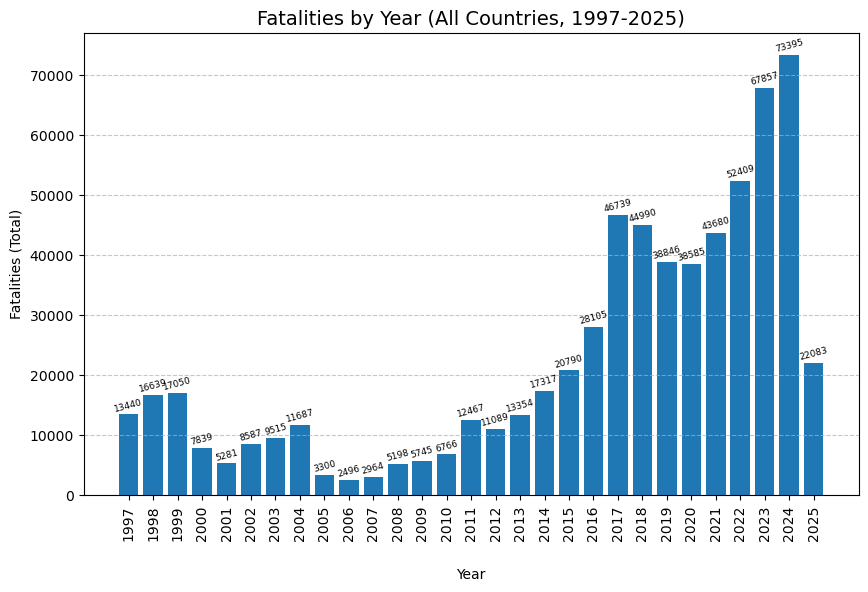

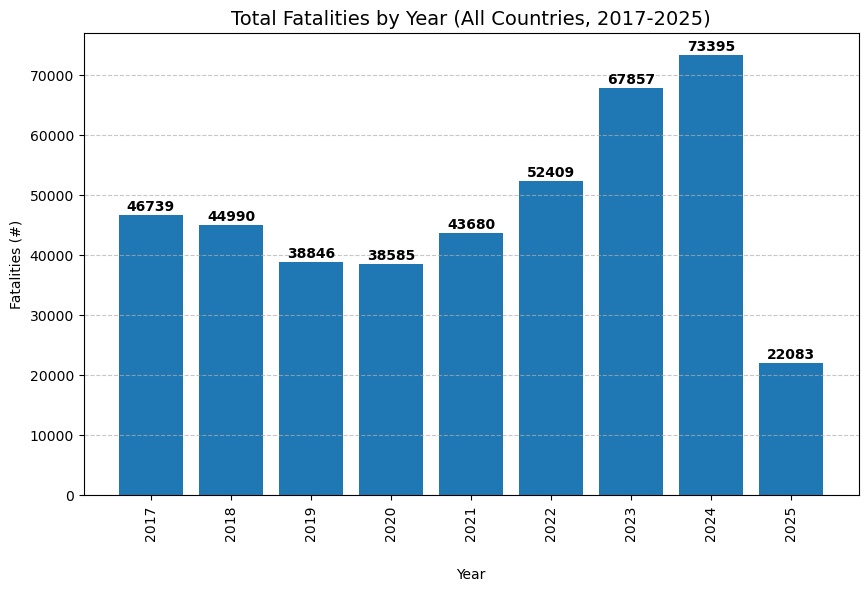

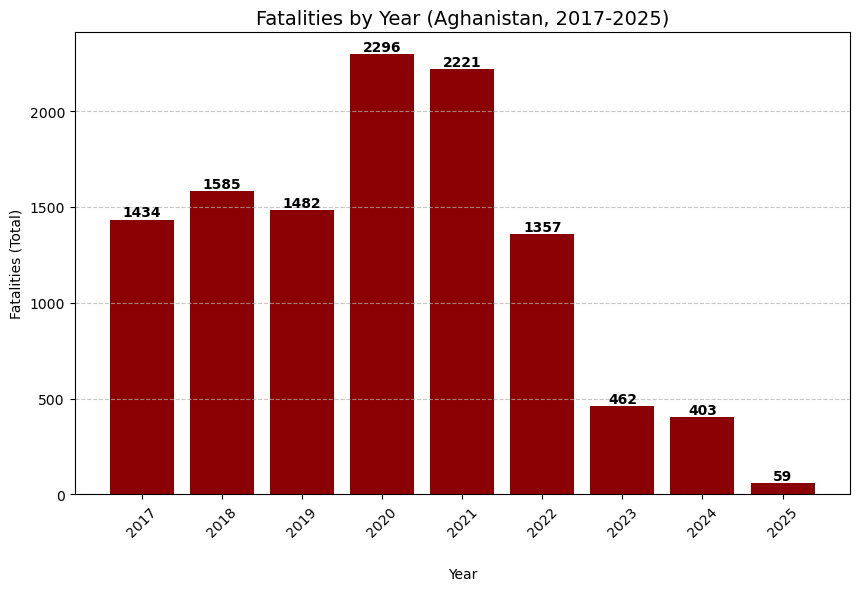

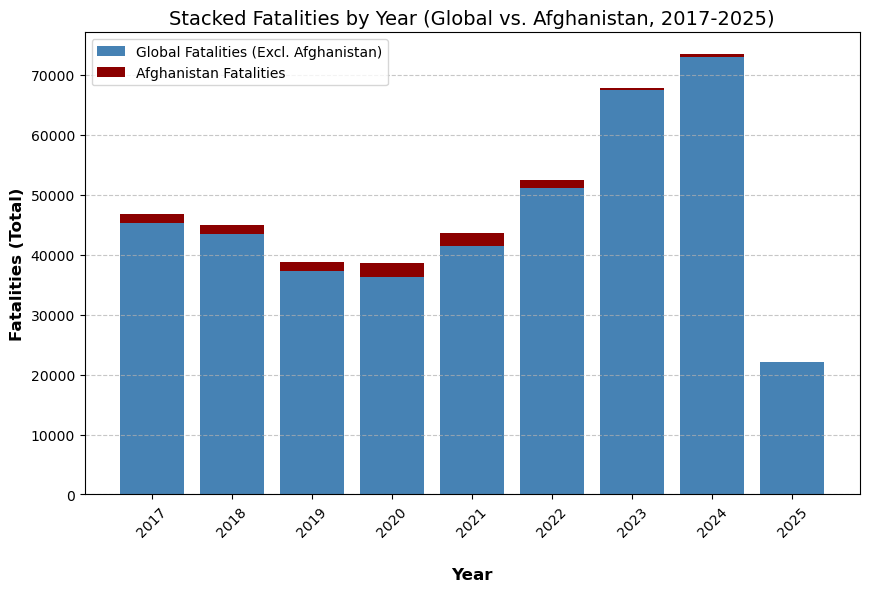

In [76]:
#Fatalities by Year
#Naive plot, a bit skewed to the right due to low fatalities, then a few outliers past 600+ fatalities

#Plot. 1 All Fatalities Bar Plot
plt.figure(figsize=(10, 6))
all_fatalities_plot = plt.bar(yearly_fatalities_all.index, yearly_fatalities_all.values)

for bar in all_fatalities_plot:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 200, int(y), ha='center', va='bottom', fontsize=6.5, rotation=15, color='black')

plt.xlabel("Year", labelpad=20)
plt.xticks(yearly_fatalities_all.index, rotation=90)
plt.ylabel("Fatalities (Total)")
plt.title("Fatalities by Year (All Countries, 1997-2025)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Plot. 2 All Fatalities Bar Plot (2017-25)
plt.figure(figsize=(10, 6))
all_fatalities_17 = plt.bar(yearly_fatalities_recent.index, yearly_fatalities_recent.values)

for bar in all_fatalities_17:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 200, int(y), ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.xlabel("Year", labelpad=20)
plt.xticks(yearly_fatalities_recent.index, rotation=90)
plt.ylabel("Fatalities (#)")
plt.title("Total Fatalities by Year (All Countries, 2017-2025)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Plot. 3 Afghanistan Fatalities Bar Plot
plt.figure(figsize=(10, 6))
all_fatalities_af = plt.bar(yearly_fatalities_af.index, yearly_fatalities_af.values, color='darkred')

for bar in all_fatalities_af:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.2, int(y), ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.xlabel("Year", labelpad=20)
plt.xticks(yearly_fatalities_af.index, rotation=45, fontsize=10)
plt.ylabel("Fatalities (Total)")
plt.title("Fatalities by Year (Aghanistan, 2017-2025)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Plot. 4 Stacked Fatalities (Global & Afghanistan, 2017-25)

years = yearly_fatalities_recent.index
afg_values = yearly_fatalities_af.reindex(years, fill_value=0)
global_values = yearly_fatalities_recent - afg_values

plt.figure(figsize=(10, 6))
plt.bar(years, global_values, label='Global Fatalities (Excl. Afghanistan)', color='steelblue')
plt.bar(years, afg_values, bottom=global_values, label='Afghanistan Fatalities', color='darkred')
plt.xlabel("Year", labelpad=20, fontsize=12, fontweight='bold')
plt.ylabel("Fatalities (Total)", fontsize=12, fontweight='bold')
plt.title("Stacked Fatalities by Year (Global vs. Afghanistan, 2017-2025)", fontsize=14)
plt.xticks(years, rotation=45, fontsize=10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Observations and Limitations:**
- Full dataset has a timeframe from 1997-2025
- Aghanistan analytical sample only covers from 2017-25
- The Taliban took over the government in 2021, and there has been a decrease since then, compared to the upward trend globally
- As previously stated, the total number of fatalities is 633k. The relative percent of Afghanistan contribution to total fatalities is 1.74%.
- In the same time period (2017-25), 259k took place globally and 11k in Afghanistan, or a contribution of 4.3%.

/var/folders/z3/_4r433cx6vb0c7n920xjj_g80000gn/T/ipykernel_54908/305183801.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



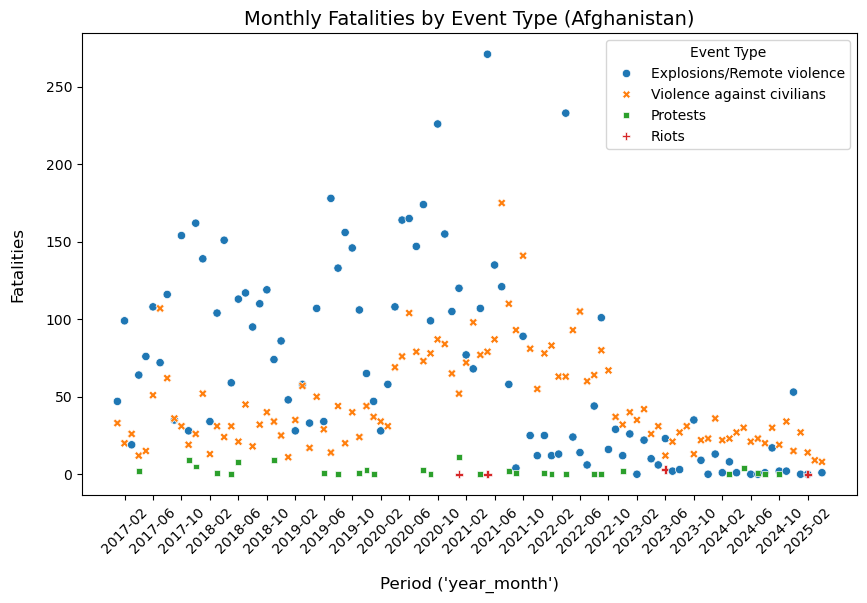

In [77]:
#Plot. 5 Scatterplot of Fatalities by Event Type and Group
df_af.loc[:, 'year_month'] = pd.to_datetime(df_af['event_date']).dt.to_period('M').astype(str)
monthly_fatalities_af = df_af.groupby(['year_month', 'event_type'])['fatalities'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=monthly_fatalities_af, x='year_month', y='fatalities', hue='event_type', style='event_type', palette='tab10')
plt.title("Monthly Fatalities by Event Type (Afghanistan)", fontsize=14)
plt.xlabel("Period ('year_month')", fontsize=12, labelpad=15)
plt.ylabel("Fatalities", fontsize=12, labelpad=15)
unique_months = monthly_fatalities_af['year_month'].unique()
tick_positions = range(1, len(unique_months), 4)  # Every 3rd month
plt.xticks(tick_positions, unique_months[tick_positions], rotation=45)
plt.legend(title="Event Type", bbox_to_anchor=(1, 1), loc='upper right')
plt.show()


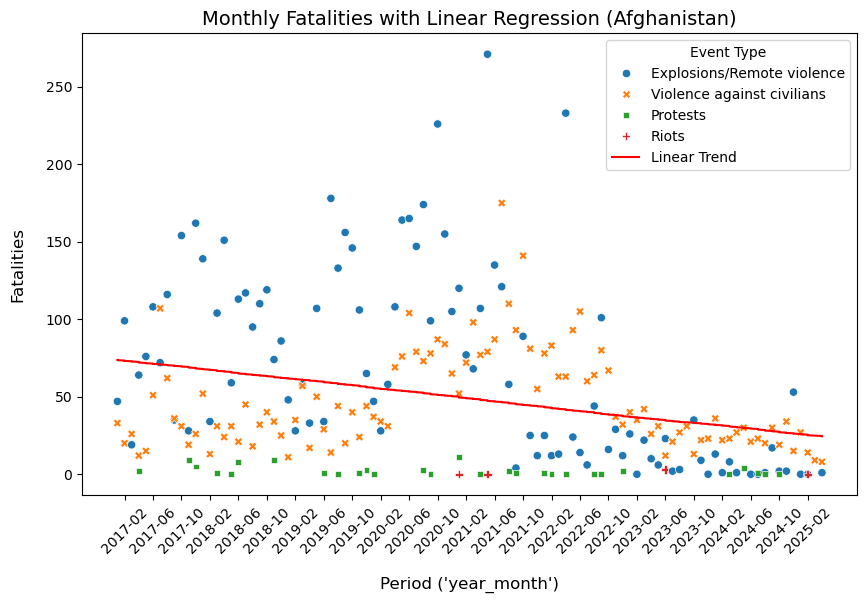

In [78]:
#Monthly Fatalities with Linear Regression

X = np.arange(len(monthly_fatalities_af)).reshape(-1, 1) #Numeric representation of time
y = monthly_fatalities_af['fatalities'].values

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)

plt.figure(figsize=(10,6))
sns.scatterplot(data=monthly_fatalities_af, x='year_month', y='fatalities', hue='event_type', style='event_type', palette='tab10')
plt.plot(monthly_fatalities_af['year_month'], y_pred, color='red', label='Linear Trend')
plt.title("Monthly Fatalities with Linear Regression (Afghanistan)", fontsize=14)
plt.xlabel("Period ('year_month')", fontsize=12, labelpad=15)
plt.ylabel("Fatalities", fontsize=12, labelpad=15)
unique_months = monthly_fatalities_af['year_month'].unique()
tick_positions = range(1, len(unique_months), 4)  # Every 3rd month
plt.xticks(tick_positions, unique_months[tick_positions], rotation=45)
plt.legend(title="Event Type", bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

**Observations:**
- The model registers a downward trend towards less fatalities, but this is oversimplified. 
- Overall, the linear model is not a good fit, since there is high variance on both sides of the line.
- There could be overestimation of lows and underestimation of peaks.

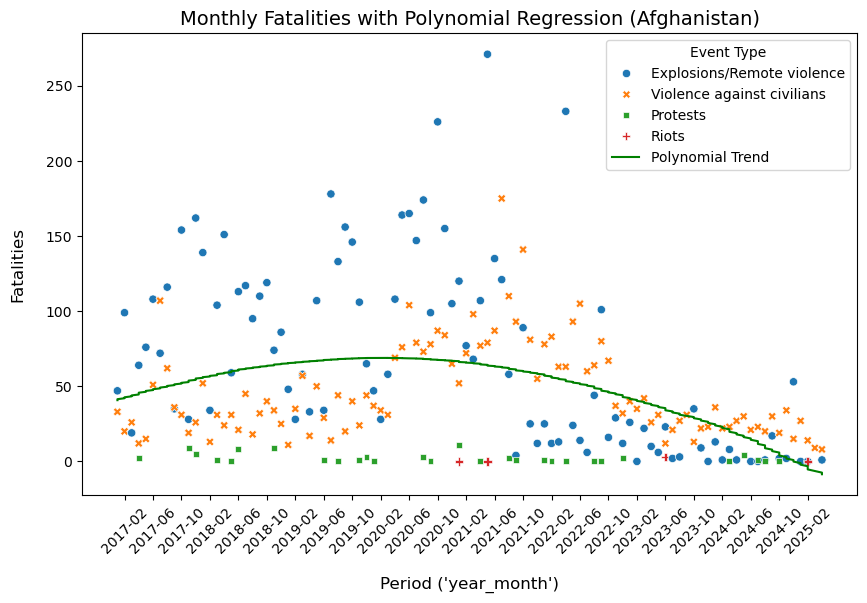

In [79]:
#Monthly Fatalities with Polynomial Regression

# Model Fit
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, y)

# Predicting Values
y_pred_poly = model_poly.predict(X_poly)

plt.figure(figsize=(10,6))
sns.scatterplot(data=monthly_fatalities_af, x='year_month', y='fatalities', hue='event_type', style='event_type', palette='tab10')
plt.plot(monthly_fatalities_af['year_month'], y_pred_poly, color='green', label='Polynomial Trend')
plt.title("Monthly Fatalities with Polynomial Regression (Afghanistan)", fontsize=14)
plt.xlabel("Period ('year_month')", fontsize=12, labelpad=15)
plt.ylabel("Fatalities", fontsize=12, labelpad=15)
unique_months = monthly_fatalities_af['year_month'].unique()
tick_positions = range(1, len(unique_months), 4)  # Every 3rd month
plt.xticks(tick_positions, unique_months[tick_positions], rotation=45)
plt.legend(title="Event Type", bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

**Observations:**
- The model registers a concacave shape representing the rise and fall of fatalities. 
- Overall, the Polynomial model is a better fit given the high variance, but the outliers could be understimated (e.g. over 200+ fatalities)
- There could be overestimation of lows and underestimation of peaks.

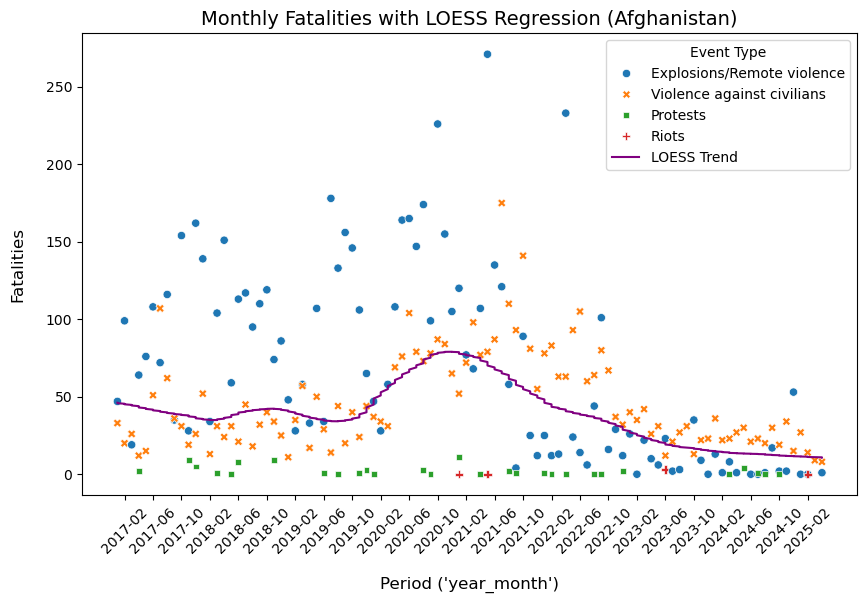

In [80]:
#Monthly Fatalities with LOESS/LOWESS (Local Weighted Scatterplot Smoothing)

# Model Fit
lowess_model = sm.nonparametric.lowess(y, X.flatten(), frac=0.2)

plt.figure(figsize=(10,6))
sns.scatterplot(data=monthly_fatalities_af, x='year_month', y='fatalities', hue='event_type', style='event_type', palette='tab10')
plt.plot(monthly_fatalities_af['year_month'], lowess_model[:, 1], color='purple', label='LOESS Trend')
plt.title("Monthly Fatalities with LOESS Regression (Afghanistan)", fontsize=14)
plt.xlabel("Period ('year_month')", fontsize=12, labelpad=15)
plt.ylabel("Fatalities", fontsize=12, labelpad=15)
unique_months = monthly_fatalities_af['year_month'].unique()
plt.xticks(tick_positions, unique_months[tick_positions], rotation=45)
plt.legend(title="Event Type", bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

**Observations:**
- The LOESS model registers a the best fit with local changes, capturing transitions peaks and falls of fatalities. 
- There seem to be issues towars the mid-part of the distribution, where sharp peaks and outliers could be too sensitive or overfit.

We know the event, but may not know all the fatalities (delay of reporting). Test training split by time, test set is 2024. We should not include 2025.

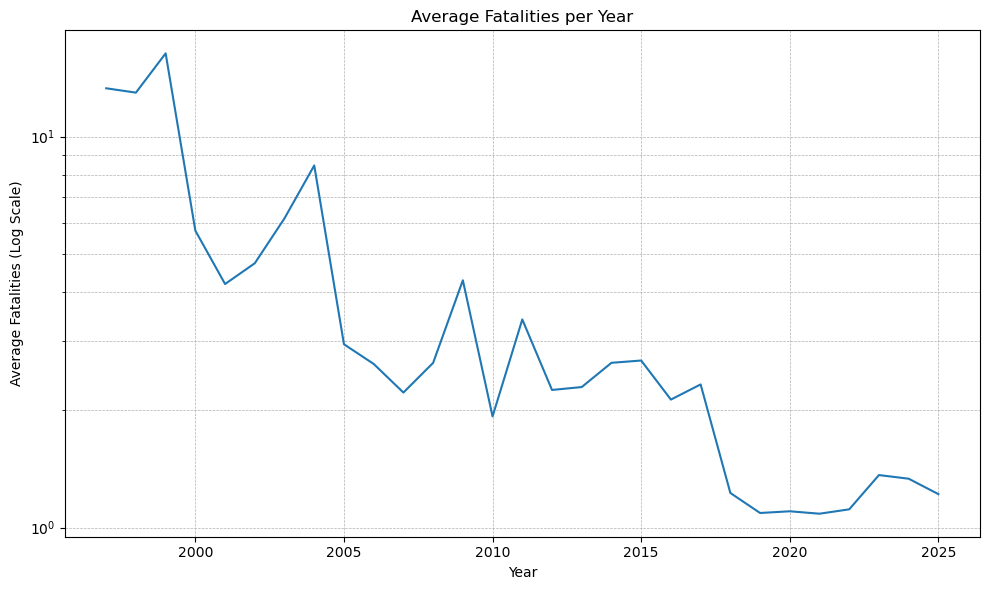

In [81]:
#Fatalities by Year

#We see a decreasing trend, so how have conflicts moved, and where are they taking place today?

yearly_avg = df_acled.groupby('year')['fatalities'].mean()

plt.figure(figsize=(10,6))
plt.plot(yearly_avg.index, yearly_avg.values)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Average Fatalities (Log Scale)')
plt.title('Average Fatalities per Year')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

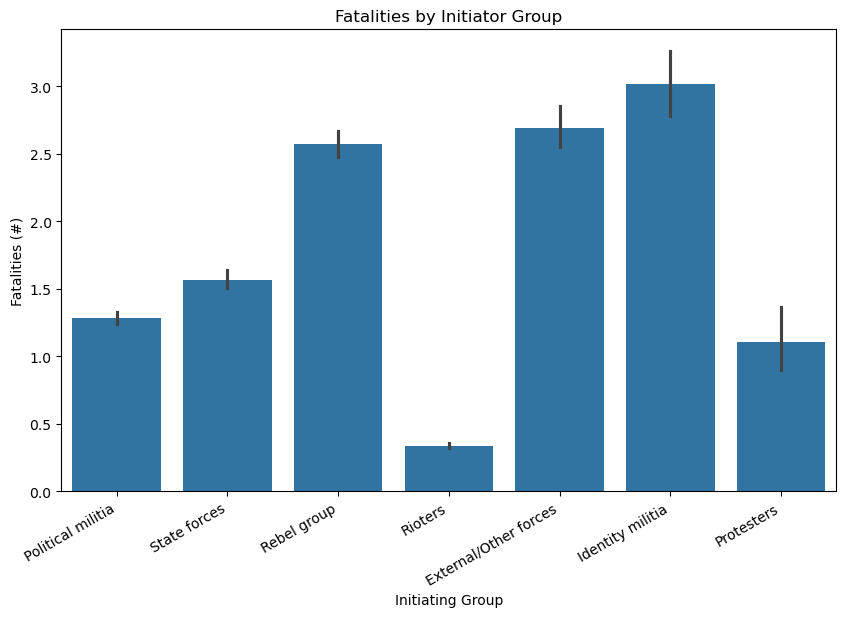

In [82]:
#Fatalities by Perpetrator

plt.figure(figsize=(10, 6))
sns.barplot(x=df_acled['inter1'], y=df_acled['fatalities'])
plt.xticks(rotation=30, ha='right')  # Tilt x-labels for readability
plt.xlabel("Initiating Group")
plt.ylabel("Fatalities (#)")
plt.title("Fatalities by Initiator Group")
plt.show()

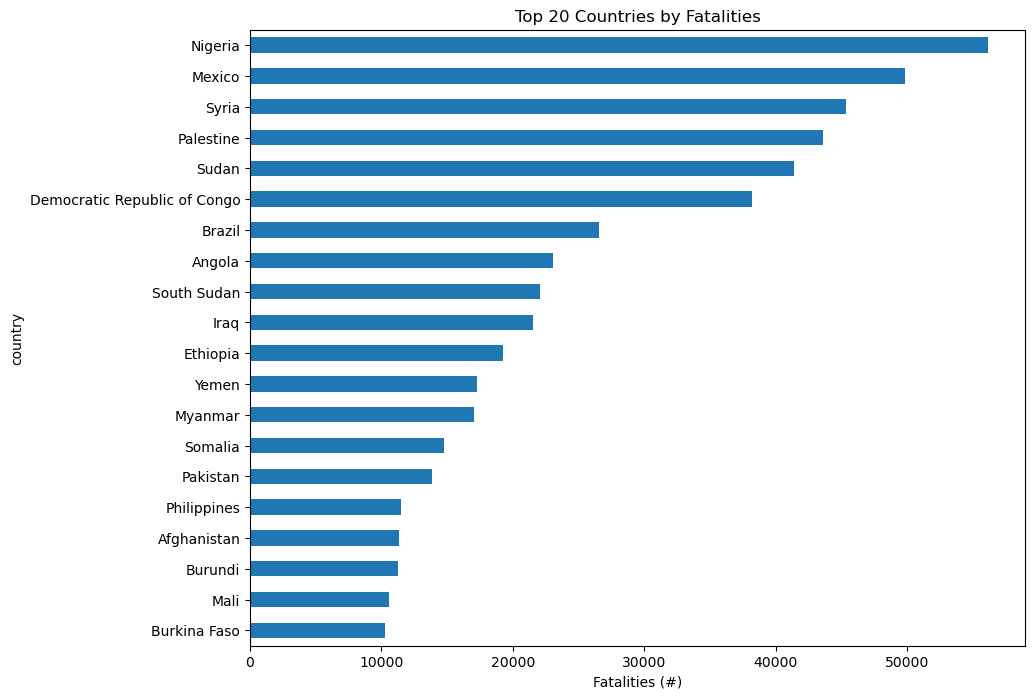

In [83]:
country_totals = df_acled.groupby("country", as_index=False)['fatalities'].sum()
top_n = country_totals.sort_values('fatalities', ascending=False).head(20)
top_n.plot(kind="barh", x='country', y='fatalities', legend=False, figsize=(10, 8))
plt.xlabel("Fatalities (#)")
plt.title("Top 20 Countries by Fatalities")
plt.gca().invert_yaxis()

# Model 1: Classification (using XGBClassifier)

For this analysis:
- fatalities were binned by month to low, mid, high
- output: predict the class label of 2024
- note: "Actor1 and Actor2 refer to the involved parties in an event. The designation of groups is not based on any specific criteria. Coding does not imply that they are the aggressor or initiated the action, nor does it imply that either reacted later, suffered more casualties, or was a victim in an event. The Notes column may contain these details if reported in the source information, though this information may be biased."

In [84]:
#Version with modified Timestamps
df_af_clean = df_af.copy()

df_af_clean['month'] = pd.to_datetime(df_af_clean['year_month']).dt.month

df_af_clean.dtypes

event_id_cnty                 object
event_date                    object
year                           int64
time_precision                 int64
disorder_type                 object
event_type                    object
sub_event_type                object
actor1                        object
assoc_actor_1                 object
inter1                        object
actor2                        object
assoc_actor_2                 object
inter2                        object
interaction                   object
civilian_targeting            object
iso                            int64
region                        object
country                       object
admin1                        object
admin2                        object
admin3                        object
location                      object
latitude                     float64
longitude                    float64
geo_precision                  int64
source                        object
source_scale                  object
n

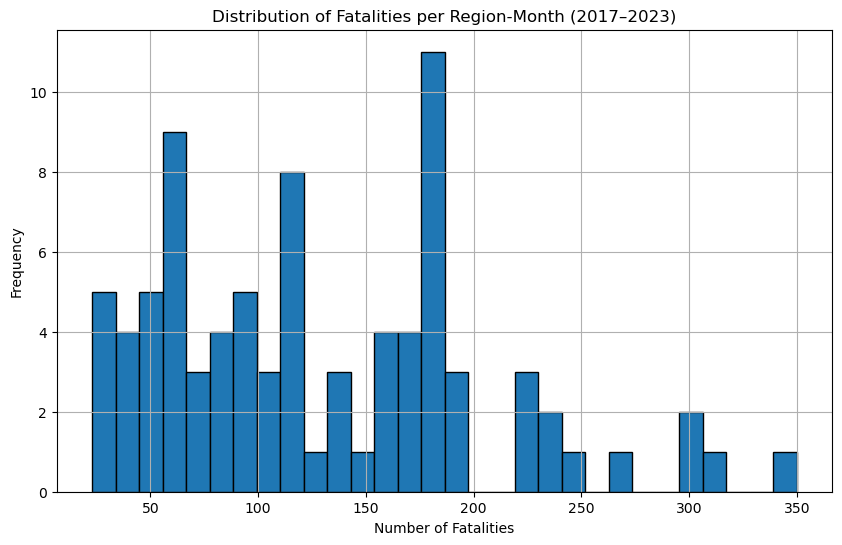

count    7940.000000
mean        1.423048
std         4.041914
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max       104.000000
Name: fatalities, dtype: float64

In [85]:
#Fatalities check before defining thresholds

fatal_check = df_af_clean[(df_af_clean['year'] >= 2017) & (df_af_clean['year'] <= 2023)]

# Aggregate to region-month level, summing fatalities
fatal_month = fatal_check.groupby(['region', 'year', 'month'])['fatalities'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.hist(fatal_month['fatalities'], bins=30, edgecolor='black')
plt.title('Distribution of Fatalities per Region-Month (2017–2023)')
plt.xlabel('Number of Fatalities')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#The data is mostly skewed to the right, meaning that after a certain threshold, our classes could lose meaning

df_af_clean['fatalities'].describe()

- Our data 75% of our data registers 1 fatality only, with a std. dev. of 4 and the max number being 104 fatalities
- Anything beyond a std. dev. of 4 should be considered high by these standards

In [86]:
#Create a dummy for violence against civilians, 0 no, 1 yes
df_af_clean['vac_dummy'] = (df_af_clean['event_type'] == 'Violence against civilians').astype(int)

#Threshold for classification labeling

def classify_fatalities(x):
    if x == 0:
        return 'none'
    elif x == 1:
        return 'low'
    elif x <= 5:
        return 'mid'
    else:
        return 'high'

df_af_clean['fatality_level'] = df_af_clean['fatalities'].apply(classify_fatalities)


In [87]:
#Drop 2025 will not be used
df_af_clean = df_af_clean[df_af_clean['year'] < 2025]  # Exclude 2025+

#Train/test split initial split
train_data = df_af_clean[df_af_clean['year'] < 2024]  
test_data  = df_af_clean[df_af_clean['year'] == 2024] 

In [88]:
#Feature and label definition
y_train = train_data['fatality_level']
y_test = test_data['fatality_level']

features = ['event_type', 'sub_event_type','actor1', 'actor2', 'location', 'disorder_type',
            'year', 'month', 'geo_precision', 'latitude', 'longitude', 'fatalities', 'vac_dummy']

X_train = train_data[features]
X_test = test_data[features]

In [89]:
#Encoding of the target variable (currently its on a none to high level)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [90]:
#Dropped the following for redundancy: ISO, timestamp and other duplicates of information; tags and text info also removed (e.g. Notes)

categorical_features = ['event_type', 'sub_event_type','actor1', 'actor2', 'location', 'disorder_type']

numerical_features = ['year', 'month', 'geo_precision', 'latitude', 'longitude','vac_dummy']

#Preprocessors for numerical and categorical data
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

#Use the preprocessor to transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [91]:
#Multi-class Classification Model

model_classification = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)


#Fit the model on training
model_classification.fit(X_train_processed, y_train_encoded)

#Predict labels
y_pred_encoded = model_classification.predict(X_test_processed)

#Recode
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_true = label_encoder.inverse_transform(y_test_encoded)

print(classification_report(y_true, y_pred))

#Note, first run had a 100% accuracy, but because fatalities was included so it predicts the level accurately, removed for a second run
#Second run performs better on high fatalities, should run some error tests, then check class imbalances

              precision    recall  f1-score   support

        high       0.71      0.50      0.59        10
         low       0.51      0.71      0.59       192
         mid       0.20      0.03      0.05        34
        none       0.77      0.66      0.71       320

    accuracy                           0.63       556
   macro avg       0.55      0.47      0.48       556
weighted avg       0.64      0.63      0.63       556



In [92]:
#Side by side map pred vs. true: Prep of data 
test_data_copy = test_data.copy()
test_data_copy['true_label'] = label_encoder.inverse_transform(y_test_encoded)
test_data_copy['predicted_label'] = label_encoder.inverse_transform(y_pred_encoded)

In [108]:
#Here we filter to only tested events, meaning those who were actually classified
test_data_copy = test_data_copy.dropna(subset=['latitude', 'longitude', 'true_label', 'predicted_label'])

#Reordering so that the display goes from none to high
fatality_order = CategoricalDtype(categories=['none', 'low', 'mid', 'high'], ordered=True)

test_data_copy['true_label'] = pd.Categorical(test_data_copy['true_label'], 
                                              categories=['none', 'low', 'mid', 'high'], 
                                              ordered=True)

test_data_copy['predicted_label'] = pd.Categorical(test_data_copy['predicted_label'], 
                                                   categories=['none', 'low', 'mid', 'high'], 
                                                   ordered=True)

map_style = "carto-positron"

color_map = {
    'none': 'green',
    'low': 'blue',
    'mid': 'purple',
    'high': 'red'
}

category_order1 = {'predicted_label': ['none', 'low', 'mid', 'high']}
category_order2 = {'true_label': ['none', 'low', 'mid', 'high']}

#True labels plot
fig_true = px.scatter_mapbox(
    test_data_copy,
    lat="latitude",
    lon="longitude",
    color="true_label",
    color_discrete_map=color_map,
    category_orders=category_order2,
    zoom=5,
    height=700,
    title="True Fatality Level (2024)",
    mapbox_style=map_style
)

#Predicted labeld plot
fig_pred = px.scatter_mapbox(
    test_data_copy,
    lat="latitude",
    lon="longitude",
    color="predicted_label",
    color_discrete_map=color_map,
    category_orders=category_order,
    zoom=5,
    height=700,
    title="Predicted Fatality Level (2024)",
    mapbox_style=map_style
)

#Render both in browser
pio.renderers.default = "browser"
fig_true.show()
pio.renderers.default = "browser"
fig_pred.show()


/var/folders/z3/_4r433cx6vb0c7n920xjj_g80000gn/T/ipykernel_54908/326117608.py:28: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/z3/_4r433cx6vb0c7n920xjj_g80000gn/T/ipykernel_54908/326117608.py:42: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

